In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function, division
import os, sys
import numpy as np, scipy as sp, pandas as pd
import scipy.io
import scipy.signal as signal, scipy.fftpack as ftpk, scipy.integrate as integrate, scipy.interpolate as interpolate
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
import tflearn
from sklearn import linear_model as lm, neural_network as nn

original_dir = os.getcwd()

In [3]:
PLOT=True

In [4]:
e = np.exp(1)
pi = np.pi
pii = np.pi*1j
twopi = np.pi * 2
SR=400

In [5]:
import pywt
# import pyhht

In [6]:
from imp import reload
import glob

In [7]:
# os.chdir(original_dir + '/..')
os.chdir('/home/mike/ve/ml/')
print(os.getcwd())
from eegkaggle.vectorizers import naive, spectral
from eegkaggle.dio import dataio
from eegkaggle.plotting import plotstuff
from eegkaggle.msignal import wavelets, metrics, auxfilter, msig

/home/mike/ve/ml


In [8]:
reload(plotstuff)
reload(dataio)

<module 'eegkaggle.dio.dataio' from 'eegkaggle/dio/dataio.pyc'>

In [9]:
matplotlib.style.use('ggplot')

In [10]:
ssmall,smed, slarge, slong = (4,3), (8,6), (16,12), (16,4)
matplotlib.rcParams['figure.figsize'] = smed

Functions

Data loading section

In [11]:
basedir = '/run/media/mike/Elements/data/kaggle/melbourne/vectors/'
data_train = np.load(basedir + 'vec_1478816228.31.npy')
names_train = pd.read_csv(basedir + 'vec_1478816228.31_name.csv')
data_test = np.load(basedir + 'vec_1478825795.45.npy')
names_test = pd.read_csv(basedir + 'vec_1478825795.45_name.csv')
print(data_train.shape, data_test.shape)

(6041, 1024, 16) (1908, 1024, 16)


In [12]:
data_train = np.nan_to_num(data_train)
data_test = np.nan_to_num(data_test)

In [13]:
names_train['label'] = [ int(name[-5]) for name in names_train['path']]
print(names_train.shape, names_train['label'].mean())
names_train.head()

(6041, 3) 0.0743254428075


,Unnamed: 0,path,label
0,0,/media/mike/Elements/data/kaggle/melbourne/tra...,0
1,1,/media/mike/Elements/data/kaggle/melbourne/tra...,0
2,2,/media/mike/Elements/data/kaggle/melbourne/tra...,0
3,3,/media/mike/Elements/data/kaggle/melbourne/tra...,0
4,4,/media/mike/Elements/data/kaggle/melbourne/tra...,0


In [14]:
name_mask = names_train['label'] == 0
name_mask1 = ~name_mask # not necessary, I just goof'd
print(name_mask.shape, name_mask.mean())
name_mask.head()

(6041,) 0.925674557193


0    True
1    True
2    True
3    True
4    True
Name: label, dtype: bool

In [15]:
# this section is suspect
# d0 = data_train * name_mask.reshape([6041,1,1])
# d1 = data_train* ~name_mask.reshape([6041,1,1])
# n0, n1 = np.count_nonzero(d0[:,512,0]), np.count_nonzero(d1[:,512,0])
# print(n0, n1)

In [16]:
# if PLOT: plt.plot(np.mean(np.mean(data_train, axis=2)==0, axis=1))

'Average (LOGT) power by channel'

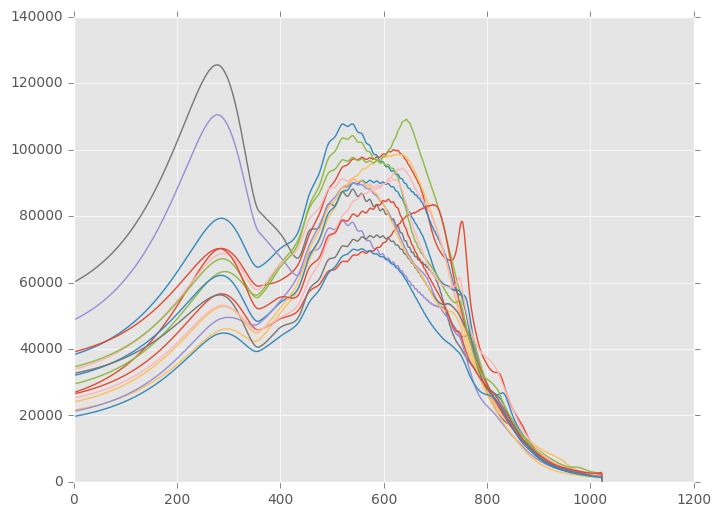

In [17]:
if PLOT: plt.plot(np.mean(data_train, axis=0))
'Average (LOGT) power by channel'

In [18]:
try:
    if PLOT: plt.plot(np.sum(d0, axis=0) / n0, c='k')
    if PLOT: plt.plot(np.sum(d1, axis=0) / n1, c='r')
except NameError:
    print('name not loaded')
'data set 0 vs 1'


name not loaded


'data set 0 vs 1'

In [19]:
try:
    if PLOT: plt.plot(np.mean(np.sum(d0, axis=0) / n0, axis=1), c='k')
    if PLOT: plt.plot(np.mean(np.sum(d1, axis=0) / n1, axis=1), c='r')
except NameError:
    print('name not loaded')

name not loaded


# NICE!

In [20]:
 # avg along electrodes
# simple_dtrain = np.mean(data_train, axis=2)
# simple_dtest = np.mean(data_test, axis=2)
subdiv = 64
simple_dtrain = data_train[:,::subdiv,:].reshape(-1,1024*16//subdiv)
simple_dtest = data_test[:,::subdiv,:].reshape(-1,1024*16//subdiv)

## THIS IS VERY SUSPECT
# Normalize ghetto style

mean = np.array(np.mean(simple_dtrain))
std = np.array(np.std(simple_dtrain))
simple_dtrain = simple_dtrain - mean
simple_dtest = simple_dtest - std
simple_dtrain = simple_dtrain / std 
simple_dtest = simple_dtest / std
print(simple_dtrain.shape, simple_dtest.shape)

(6041, 256) (1908, 256)


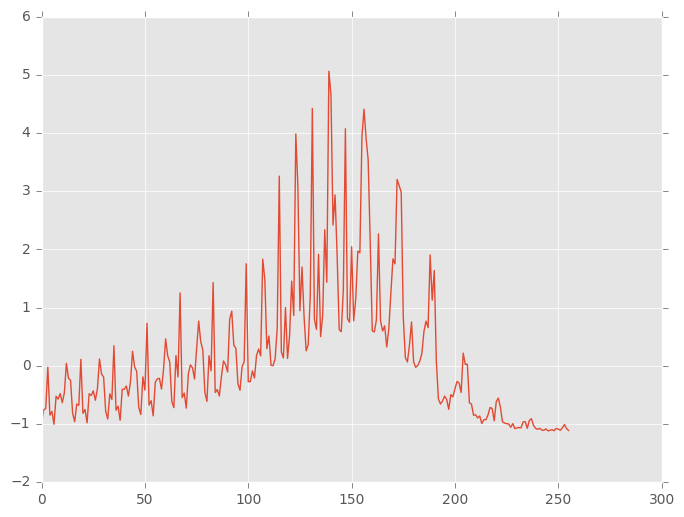

In [21]:
plt.plot(simple_dtrain[3])

In [22]:
y = np.vstack([name_mask, ~name_mask]).T # label vector will be (N, S), N hot for 'no seiz', S hot for 'seize'
print(y.shape)

(6041, 2)


In [23]:
dtrain_set = np.concatenate([simple_dtrain, y], axis=1)
dtrain_set.shape

(6041, 258)

In [24]:
dframe = pd.DataFrame(dtrain_set)

In [25]:
d0 = dframe[dframe.iloc[:,-1] == 0]
d1 = dframe[dframe.iloc[:,-1] == 1]
print(d0.shape, d1.shape)
nfalse, nhit = d0.shape[0], d1.shape[0]

(5592, 258) (449, 258)


In [26]:
offset = np.random.randint(0, nfalse-nhit-1)
d0b = d0[offset:offset+nhit]
print(d0b.shape)

(449, 258)


In [27]:
d0b_ = d0b.as_matrix()
d1_ = d1.as_matrix()

d1_

array([[-0.91700531, -0.28894038, -0.34717156, ..., -1.13051259,
         0.        ,  1.        ],
       [-1.18640367, -0.25012621, -0.20001391, ..., -1.13099762,
         0.        ,  1.        ],
       [-0.89470504, -0.23833191,  0.77783794, ..., -1.12877081,
         0.        ,  1.        ],
       ..., 
       [-3.23013193, -1.15766797, -0.39704927, ..., -1.11376105,
         0.        ,  1.        ],
       [-1.91395593, -0.82024792, -0.15868652, ..., -1.10956531,
         0.        ,  1.        ],
       [-1.00638979, -0.68105726, -1.1176758 , ..., -1.11182738,
         0.        ,  1.        ]])

### Shuffle and shit

In [28]:
subdiv_vec =1
new_set = np.concatenate([d0b_, d1_], axis=0)
print('new_set:',new_set.shape)
np.random.shuffle(new_set)
print(np.mean(new_set[:nhit,-1]))
simple_dtrain= new_set[:,:-2]
simple_dtrain_lab = new_set[:,-1]
simple_dtrain = simple_dtrain[:,::subdiv_vec]
print(simple_dtrain.shape)
print(np.mean(simple_dtrain_lab[:nhit]))


new_set: (898, 258)
0.503340757238
(898, 256)
0.503340757238


In [29]:
simple_dtrain

array([[-1.14099392, -0.43335774,  1.33738681, ..., -1.09822803,
        -1.09044256, -1.11626668],
       [-1.12642415, -1.98631326,  0.28663352, ..., -1.0851981 ,
        -1.08360069, -1.11019731],
       [-1.09564718, -0.95468939, -1.73370722, ..., -1.10301365,
        -1.09068502, -1.11783462],
       ..., 
       [-0.79601541, -0.09425503,  0.8554183 , ..., -1.06195818,
        -1.09422456, -1.12446951],
       [-0.31655395,  0.32839636,  0.03730119, ..., -1.10220435,
        -1.08888705, -1.11027532],
       [ 0.66681211, -0.03796655, -0.49551697, ..., -1.0692753 ,
        -1.04420218, -1.0636483 ]])

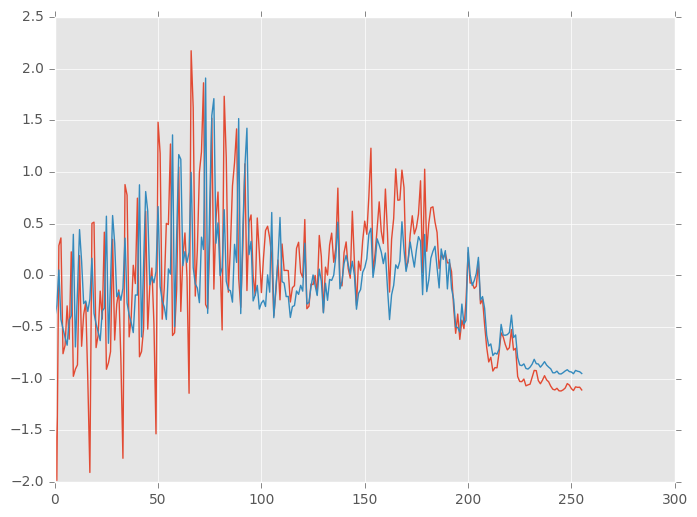

In [30]:
n = 1
plt.plot(simple_dtrain[n])
plt.plot(simple_dtest[n])

In [60]:
# Parition the data into training and evaluation sets
partition = 3*simple_dtrain.shape[0] // 4
print(partition)
print('simple_dtrain:', simple_dtrain.shape)
X=simple_dtrain[:partition]
Y=simple_dtrain_lab[:partition]
Xv=simple_dtrain[partition:]
Yv=simple_dtrain_lab[partition:]
G=simple_dtest


673
simple_dtrain: (898, 256)


In [61]:
print(Y.shape, np.mean(Y), np.mean(Yv))
print(X.shape, Y.shape, Xv.shape, Yv.shape)

(673,) 0.499257057949 0.502222222222
(673, 256) (673,) (225, 256) (225,)


In [62]:
# assert 0 # break point

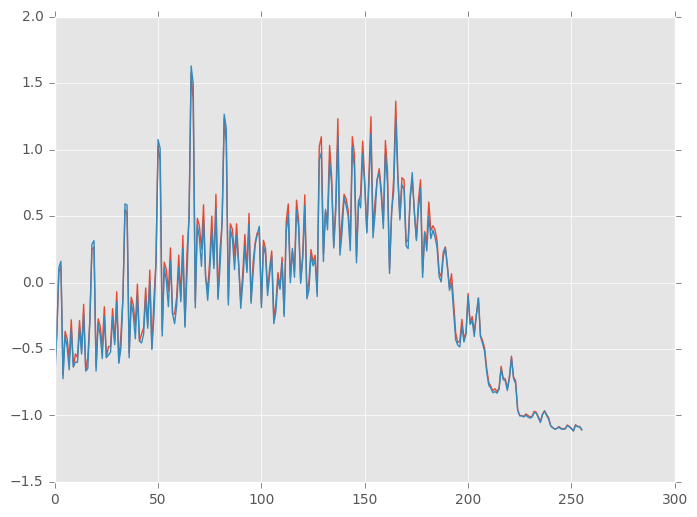

In [63]:
plt.plot(np.mean(X, axis=0))
plt.plot(np.mean(Xv, axis=0))

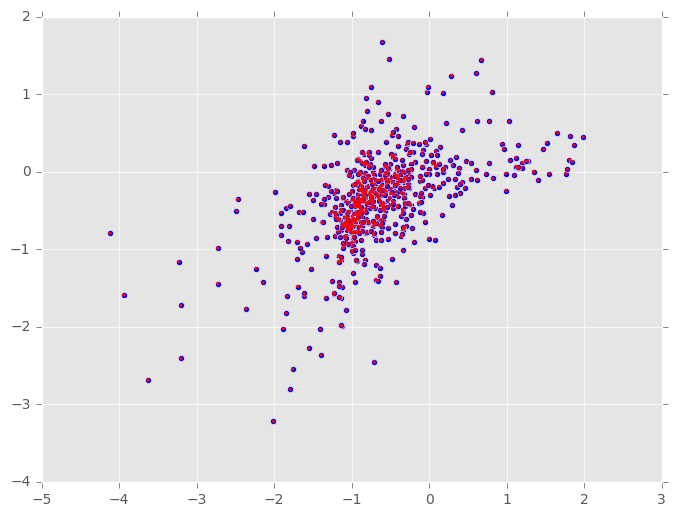

In [64]:
plt.scatter(X[:,0], X[:,1])
plt.scatter(X[:,0], X[:,1], c='r', s=5, edgecolor='none')

(673,) (673,)


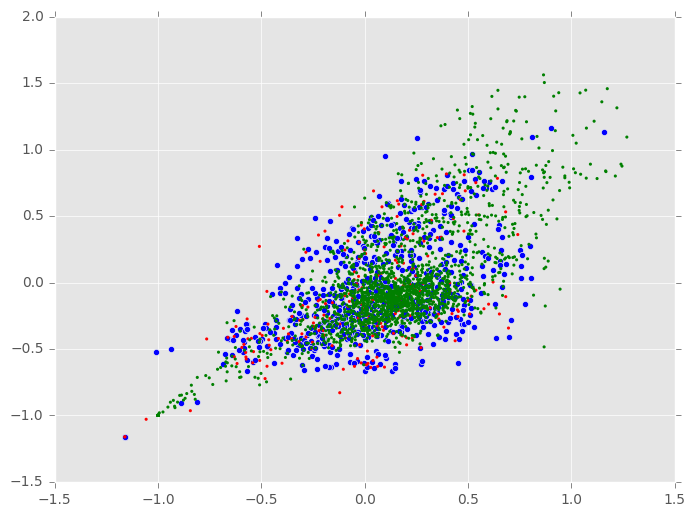

In [65]:
a = np.mean(X[:,:128], axis=1)
b = np.mean(X[:,128:], axis=1)
c = np.mean(Xv[:,:128], axis=1)
d = np.mean(Xv[:,128:], axis=1)
e = np.mean(G[:,:128], axis=1)
f = np.mean(G[:,128:], axis=1)
print(a.shape, b.shape)
plt.scatter(a ,b,)
plt.scatter(c, d, c='r', s=5, edgecolor='none')
plt.scatter(e, f, c='g', s=5, edgecolor='none')

In [53]:
perc = lm.Perceptron()

In [66]:
cut = 250
sl = 2
kf = 4
X1, Y1 = X[::kf,:cut:sl], Y[::kf]
X2, Y2 = X[1::kf,:cut:sl], Y[1::kf]
G0 = G[:, :cut:sl]

In [67]:
print(X1.shape, Y1.shape, G0.shape, np.mean(Y, axis=0))
print(np.mean(X,), np.mean(Xv), np.std(Xv, ), np.std(Xv, ), )
print(np.mean(X1,), np.mean(X2), np.std(X1, ), np.std(X2, ), )

perc.fit(X1, Y1)

(169, 125) (169,) (1908, 125) 0.499257057949
-0.0296804594464 -0.0663732529368 0.914911315787 0.914911315787
-0.0231609496897 0.0080667415365 0.913062002102 0.900374022676


Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      n_iter=5, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)

In [68]:
print( perc.score(Xv[:,:cut:sl], Yv), np.mean(Yv, axis=0))

0.791111111111 0.502222222222


In [69]:
print( perc.score(X1, Y1), np.mean(Yv, axis=0))
print( perc.score(X2, Y2), np.mean(Yv, axis=0))

0.869822485207 0.502222222222
0.845238095238 0.502222222222


In [70]:
pr = perc.predict(X2)
print('Expected: 0.5:',pr.mean())

Expected: 0.5: 0.619047619048


# VALIDATION

In [71]:
print('VALIDATION: ', np.mean(pr == Y2))

VALIDATION:  0.845238095238


In [44]:
names_test['guess'] = pd.Series(pr)

In [45]:
names_test['File'] = [os.path.basename(name) for name in names_test['path']]

In [46]:
names_test.to_csv('guess11_10_perc.csv')

In [47]:
ls

auc_by_channel_by_patient.png  teststereo.wav
bin/                           vec_fftsplit_9829_292.json
eegkaggle/                     vec_fftsplit_9829_292_name.csv
guess11_10_mlp_256.csv         vec_fftsplit_9829_292.npz
guess11_10_perc.csv            vec_mh_ftfc_9583_566.json
hills_seizure_detection/       vec_mh_ftfc_9583_566_name.csv
include/                       vec_mh_ftfc_9583_566.npy
kaggle-seizure-prediction/     vec_mh_ftfc_9648_087.json
lib/                           vec_mh_ftfc_9648_087_name.csv
lib64@                         vec_mh_ftfc_9648_087.npy
LICENSE                        vec_sampen_9598_376.json
logft_train_ch15.png           vec_sampen_9598_376_name.csv
logft_train_ch1.png            vec_sampen_9598_376.npy
man/                           vec_sampen_9607_384.json
michaelhills/                  vec_sampen_9607_384_name.csv
mnist_starter_pack.ipynb       vec_sampen_9607_384.npy
pip-selfcheck.json             vec_split_9829_263.json
README                         v

# SKLearn MLP

In [48]:
mlp = nn.MLPClassifier(hidden_layer_sizes=(256,32,256,32), activation='relu', warm_start=1)

In [49]:
mlp.fit(X, Y)
mlp.score(Xv, Yv)

0.93333333333333335

In [50]:
pr = mlp.predict(simple_dtest)
print(pr.mean())

0.769392033543


In [51]:
names_test['Class'] = pd.Series(pr)
names_test['File'] = [os.path.basename(name) for name in names_test['path']]

In [52]:
assert 0, 'woah doggies'

AssertionError: woah doggies

In [ ]:
guessfile = names_test[['File', 'Class']]
guessfile.to_csv('guess11_10_mlp_256.csv', index=False)